# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (cross_val_score, GridSearchCV)
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

np.random.seed(23)

In [2]:
X_train = pd.read_csv('../data/x_train_processed.csv')
X_test = pd.read_csv('../data/x_test_processed.csv')
y_train = pd.read_csv('../data/y_train_processed.csv')
y_test = pd.read_csv('../data/y_test_processed.csv')

In [3]:
X_train.columns

Index(['children', 'seniors', 'mental', 'winter', 'daylight', 'aircrafts_1',
       'aircrafts_2', 'area_type_unknown', 'area_type_urban_rural',
       'area_type_water', 'area_type_wilderness', 'state_Arizona',
       'state_California', 'state_Colorado', 'state_Idaho', 'state_Nevada',
       'state_New Jersey', 'state_New Mexico', 'state_Oregon',
       'state_Pennsylvania', 'state_Utah', 'state_Vermont', 'state_Washington',
       'number_subjects', 'number_volunteers'],
      dtype='object')

In [4]:
print(X_train.shape, '\n', 
      y_train.shape, '\n', 
      X_test.shape, '\n', 
      y_test.shape)

(8600, 25) 
 (8600, 1) 
 (2150, 25) 
 (2150, 1)


# Logistic Regression Model

In [5]:
logreg_params = {'penalty': ['l1', 'l2'], 
                 'solver': ['liblinear', 'saga']
                }

logreg_gridsearch = GridSearchCV(LogisticRegression(max_iter=5000), 
                                 logreg_params, 
                                 cv=5)

logreg_gridsearch.fit(X_train, y_train.values.ravel())

print(logreg_gridsearch.best_estimator_)
print(logreg_gridsearch.best_params_)

print('\nBaseline: 35%')

print('\nBest Score:', round(logreg_gridsearch.best_score_, 4))
print('Test Score:', round(logreg_gridsearch.score(X_test, y_test.values.ravel()), 4))

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')
{'penalty': 'l1', 'solver': 'saga'}

Baseline: 35%

Best Score: 0.568
Test Score: 0.5656


In [6]:
logreg = LogisticRegression(max_iter=5000, 
                            penalty=logreg_gridsearch.best_params_['penalty'],  
                            solver=logreg_gridsearch.best_params_['solver'],
                            random_state=23)

logreg.fit(X_train, y_train.values.ravel())

train_scores = cross_val_score(logreg, X_train, y_train.values.ravel())
test_scores = cross_val_score(logreg, X_test, y_test.values.ravel())

print('Baseline: 35%\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 35%

Train scores: [0.56162791 0.56744186 0.57267442 0.56511628 0.57325581]
Mean: 0.568
Stdev: 0.009 

Test scores: [0.5627907  0.5627907  0.54883721 0.56976744 0.55581395]
Mean: 0.56
Stdev: 0.014 



# Coefficient Interpretation

In [7]:
coeffs = ['coeffs_' + str(i) for i in list(range(3))]
coeffs_df = pd.DataFrame()

for i, coeff in enumerate(coeffs):

    coeff = pd.DataFrame(list(zip(X_train.columns, np.expm1(logreg.coef_[i]))), 
                         columns=['features_'+str(i), 'coeff_'+str(i)])
    
    coeff['abs_'+str(i)] = round(abs(coeff['coeff_'+str(i)]), 2)
    coeff['coeff_'+str(i)] = round(coeff['coeff_'+str(i)], 2)
    
    coeff = coeff.sort_values('abs_'+str(i), ascending=False) 
    coeff.reset_index(drop=True, inplace=True)
    
    coeffs_df = pd.concat([coeffs_df, coeff], axis=1)

coeffs_df.head(10)

,features_0,coeff_0,abs_0,features_1,coeff_1,abs_1,features_2,coeff_2,abs_2
0,state_Pennsylvania,29.85,29.85,state_New Jersey,0.49,0.49,state_New Mexico,1.85,1.85
1,state_Colorado,0.83,0.83,state_Nevada,-0.21,0.21,state_Washington,1.33,1.33
2,number_volunteers,-0.75,0.75,state_Utah,-0.19,0.19,number_volunteers,1.29,1.29
3,state_Oregon,-0.73,0.73,state_California,-0.13,0.13,aircrafts_2,1.17,1.17
4,state_New Mexico,-0.63,0.63,area_type_water,0.09,0.09,state_Oregon,0.80,0.80
5,aircrafts_2,-0.59,0.59,area_type_unknown,-0.06,0.06,aircrafts_1,0.73,0.73
6,children,0.47,0.47,state_Vermont,0.04,0.04,state_Arizona,0.44,0.44
7,area_type_urban_rural,0.39,0.39,seniors,0.01,0.01,state_New Jersey,-0.42,0.42
8,mental,-0.39,0.39,state_Idaho,0.00,0.00,winter,0.42,0.42
9,state_Washington,-0.26,0.26,number_subjects,0.00,0.00,state_Vermont,-0.38,0.38


# Metrics

              precision    recall  f1-score   support

      0-11hr       0.58      0.71      0.64       698
     11-32hr       0.44      0.32      0.37       691
32hours-7day       0.63      0.65      0.64       761

    accuracy                           0.57      2150
   macro avg       0.55      0.56      0.55      2150
weighted avg       0.55      0.57      0.55      2150



''

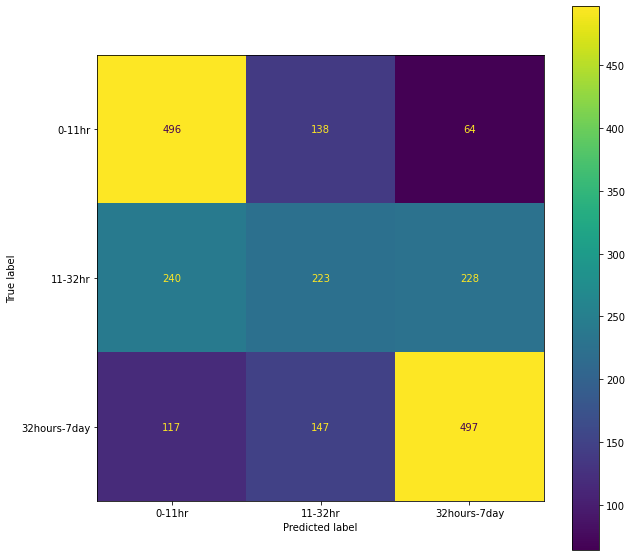

In [8]:
conmat = np.array(confusion_matrix(y_test, 
                                   logreg.predict(X_test), 
                                   labels=[0,1,2]))
print(classification_report(y_test,
                            logreg.predict(X_test), 
                            target_names=['0-11hr', '11-32hr', '32hours-7day']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=['0-11hr', '11-32hr', '32hours-7day'])

fig, ax = plt.subplots(figsize=(10,10))
matrix_display.plot(ax=ax)

# figure = plt.gcf() 
# figure.set_size_inches(10, 10)
;

# Analysis

**Metrics**
- This model is 57% accurate in predicting the target class. This is 22% more than the baseline model with a probability of 35%. 
- The model had the highest precision in predicting the 3rd class (32hours-7days) followed closely by the 1st class (0-11hours). 
- the f1 score (harmonic mean of precision and recall) for the 2nd class was roughly half of either the 1st or 3rd classes. The features captured do not capture as much signal for the 2nd class. 

**Coefficients**
- The largest coefficient for all three classes was a state. States have a high predictive power for all three classes. 
    - coeffs_0: Pennsylvania, coeffs_1:New Jersey, coeffs_2:New Mexico
- `aircraft_2`  and `aircraft_1` were one of the largest coefficients for the 1st and 3rd classes respectively. These features indicate that there were two or one type(s) of aircrafts involved in the SAR mission. 
    - `aircraft_2` being a negative coefficient for the first class indicate that incidents in this timeframe do not typically involve any aircrafts at all
    - `aircraft_1` and `aircraft_2` being positive coefficients for the 3rd class indicate that these incidents frequently invole aircrafts. 
- `number_volunteers` was was also one of the largest coefficient for both the 1st and 3rd class. 
    - being negative for the 1st class, incidents in this time frame often have few volunteers
    - being positive for the third class indicate that these incidents often have more volunteers

**Conclusion**
I binned the target total_hours into three mostly equally distributed classes. This increased the model's ability to predict the 2nd class, but ultimately reduced the accuracy of the model. This model is 2% less accurate than the Random Forest model. I would recommend implementing this model into production verses the Random Forest model soley due to the fact that it is more humanly interprettable and could give further insight into which facters are important in determing the time it takes to search for and rescue a victim. 